In [1]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint
import numpy as np

In [2]:
import pandas as pd 
import cluster_util, config

df_mlerr_g_mlbugs_unique = pd.read_excel(config.path_github_error_analysis.joinpath("df_mlerr_g_mlbugs_filtered_dedup.xlsx"))
df_mlerr_k_mlbugs_unique = pd.read_excel(config.path_kaggle_error_analysis.joinpath("df_mlerr_k_mlbugs_filtered_dedup.xlsx"))

df_mlerr_mlbugs_unique = pd.concat([df_mlerr_g_mlbugs_unique, df_mlerr_k_mlbugs_unique], ignore_index=True, sort=False)

err_descs = df_mlerr_mlbugs_unique['evalue_tokenized'].values.astype('U')

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [3]:
# Create Dictionary
processed_texts = [err.split() for err in err_descs]
id2word = corpora.Dictionary(processed_texts)
# Create Corpus, Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_texts]

## Get the optimal num_topic for LDA model

In [4]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                                         random_state=42, passes=50, iterations = 400) #alpha="auto" not implemented in LdaMulticore
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

limit=100; start=3; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_texts, start=start, limit=limit, step=step)

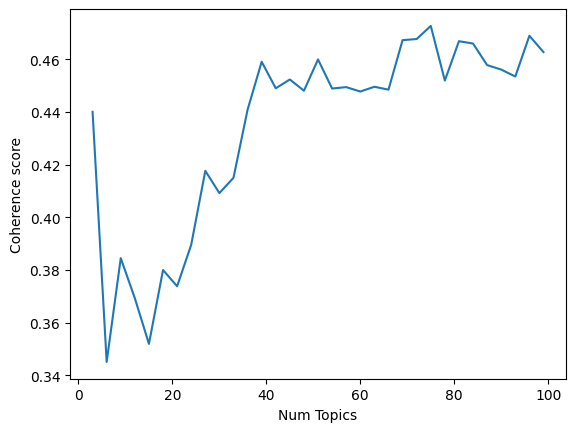

In [5]:
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
# # save the models
# for i in range(len(model_list)):
#     model = model_list[i]
#     savepath = str(config.path_default.joinpath("ldamodel{}.gensim".format(x[i])))
#     model.save(savepath)

In [84]:
# # ldamodel75
# optimal_model_id = x[np.argmax(coherence_values)] # 75
# # load a model
# modelpath = str(config.path_github_error_analysis.joinpath("ldamodel{}.gensim".format(optimal_model_id)))
# lda_model = LdaModel.load(modelpath)

In [85]:
# lda_model_op = model_list[np.argmax(coherence_values)]
# # inference
# prob_cutoff = 0.0
# res_labels = np.zeros(len(err_descs))
# for i in range(len(err_descs)):
#     top_label = sorted(lda_model_op[corpus[i]], key=lambda tup:tup[1], reverse=True)[0] #(label, probability)
#     if top_label[1] >= prob_cutoff:
#         res_labels[i] = top_label[0]
#     else:
#         res_labels[i] = -1
# print("There are {} out of {} not labeled (with highest probability lower than {})".format(sum(res_labels==-1),len(res_labels),prob_cutoff))
# # Higher coherence scores indicate a better model, [0,1]
# coherence_model_lda = CoherenceModel(model=lda_model_op, texts=processed_texts, dictionary=id2word, coherence="c_v")
# coherence_lda = coherence_model_lda.get_coherence()
# print("Coherence Score:" , coherence_lda)

There are 448 out of 13153 not labeled (with highest probability lower than 0.1)
Coherence Score: 0.4773408562541137


In [86]:
# pprint(lda_model_op.print_topics())

[(47,
  '0.336*"g" + 0.173*"br" + 0.124*"b" + 0.124*"v" + 0.080*"r" + 0.009*"bert" + '
  '0.007*"per" + 0.004*"score" + 0.004*"cased" + 0.004*"words"'),
 (22,
  '0.034*"save" + 0.028*"encountered" + 0.028*"exception" + 0.026*"ndarray" + '
  '0.024*"the" + 0.023*"inconsistent" + 0.022*"exist" + 0.019*"results" + '
  '0.017*"documents" + 0.014*"value"'),
 (2,
  '0.138*"unknown" + 0.053*"handle" + 0.049*"targets" + 0.043*"metrics" + '
  '0.040*"classification" + 0.038*"mix" + 0.036*"multiclass" + 0.031*"binary" '
  '+ 0.028*"sum" + 0.026*"multioutput"'),
 (17,
  '0.043*"new" + 0.035*"e" + 0.030*"error" + 0.027*"function" + 0.026*"var" + '
  '0.019*"text" + 0.015*"content" + 0.015*"type" + 0.012*"script" + '
  '0.012*"randomforestclassifier"'),
 (27,
  '0.098*"tensorflow" + 0.031*"head" + 0.026*"python" + 0.024*"pip" + '
  '0.017*"cat" + 0.013*"install" + 0.012*"card" + 0.012*"ncomponents" + '
  '0.010*"probability" + 0.010*"parserf"'),
 (58,
  '0.219*"file" + 0.121*"errno" + 0.118*"no" + 

## Train a lda model with predefined number of topics

In [17]:
# Set number of topics
num_topics = 75 # optimal_model_id
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                     random_state=42, passes=50, iterations = 400, #eval_every = None,
                     alpha="auto") #, per_word_topics=True

In [18]:
# lda_model.show_topic(26)
# lda_model.top_topics(corpus)

In [19]:
# inference
prob_cutoff = 0.0
res_labels = np.zeros(len(err_descs))
for i in range(len(err_descs)):
    top_label = sorted(lda_model[corpus[i]], key=lambda tup:tup[1], reverse=True)[0] #(label, probability)
    if top_label[1] >= prob_cutoff:
        res_labels[i] = top_label[0]
    else:
        res_labels[i] = -1
print("There are {} out of {} not labeled (with highest probability lower than {})".format(sum(res_labels==-1),len(res_labels),prob_cutoff))

There are 0 out of 14518 not labeled (with highest probability lower than 0.0)


In [20]:
import pickle

with open(config.path_default.joinpath("lda75.pkl"), "wb") as f:
    pickle.dump(lda_model, f)

In [21]:
# import pickle

# with open(config.path_default.joinpath("lda60.pkl"), "rb") as f:
#     lda_model_load = pickle.load(f)

In [22]:
# Print the keywords for each topic
pprint(lda_model.print_topics())

[(15,
  '0.054*"alpha" + 0.048*"block" + 0.016*"transaction" + 0.012*"ignored" + '
  '0.010*"aborted" + 0.007*"end" + 0.007*"commands" + 0.000*"lossdreal" + '
  '0.000*"cliffords" + 0.000*"istrading"'),
 (1,
  '0.071*"denied" + 0.059*"permission" + 0.041*"errno" + 0.021*"outside" + '
  '0.000*"supportvectormachine" + 0.000*"coinname" + 0.000*"onbadlines" + '
  '0.000*"tpumodel" + 0.000*"lossdreal" + 0.000*"sequentialrnn"'),
 (38,
  '0.069*"style" + 0.047*"levels" + 0.009*"markers" + 0.005*"these" + '
  '0.000*"malishev" + 0.000*"tpumodel" + 0.000*"sequentialrnn" + 0.000*"siz" + '
  '0.000*"coinname" + 0.000*"supportvectormachine"'),
 (10,
  '0.090*"base" + 0.084*"subtype" + 0.082*"literal" + 0.082*"code" + '
  '0.081*"invalid" + 0.075*"int" + 0.032*"neither" + 0.005*"subtypelive" + '
  '0.005*"subtypexbox" + 0.005*"subtypecd"'),
 (66,
  '0.017*"uninitialized" + 0.014*"debug" + 0.012*"valuecounts" + '
  '0.011*"folder" + 0.009*"also" + 0.009*"adam" + 0.008*"learningrate" + '
  '0.007*"r

In [23]:
# Higher coherence scores indicate a better model, [0,1]
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:" , coherence_lda)

Coherence Score: 0.4850225451088864


In [24]:
df_mlerr_mlbugs_unique_clusters = pd.read_excel(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_clustered.xlsx"))
# df_mlerr_mlbugs_unique_clusters.loc[:,"cluster_lda60"] = res_labels
df_mlerr_mlbugs_unique_clusters.loc[:,"cluster_lda75"] = res_labels

In [25]:
df_mlerr_mlbugs_unique_clusters.to_excel(config.path_default.joinpath("df_mlerr_mlbugs_filtered_dedup_clustered.xlsx"), index=False, engine='xlsxwriter')